In [ ]:
import numpy as np # linear algebra
import sklearn as sk
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('creditcard.csv', low_memory=False)
df.head()

Time        V1        V2        V3  ...       V27       V28  Amount  Class
0     0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62    0.0
1     0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69    0.0
2     1 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66    0.0
3     1 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50    0.0
4     2 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99    0.0

[5 rows x 31 columns]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Make another copy of df and drop the unimportant "Time" feature
data = df.drop(['Time'], axis=1) 

# Use scikit’s StandardScaler on the "Amount" feature
# The scaler removes the mean and scales the values to unit variance
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# Create the training and testing sets
X1_train, X1_test = train_test_split(data, test_size=.3, random_state=0)
X1_train = X1_train[X1_train.Class == 0] # train the model on normal transactions
X1_train = X1_train.drop(['Class'], axis=1)

y1_test = X1_test['Class']
X1_test  = X1_test.drop(['Class'], axis=1) #drop the class column


#transform to ndarray
X1_train = X1_train.values
X1_test = X1_test.values
X1_train.shape

(4180, 29)

In [ ]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X1_train.shape[1] #num of columns, 29
encoding_dim = 14
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, 
                activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
nb_epoch = 100
batch_size = 128
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

checkpointer = ModelCheckpoint(filepath='autoencoder_fraud.h5',
                               save_best_only=True,
                               verbose=0)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X1_train, X1_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X1_test, X1_test),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history


Epoch 1/100
33/33 [==============================] - 1s 13ms/step - loss: 0.6176 - accuracy: 0.6390 - val_loss: nan - val_accuracy: 0.6352
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 0.6169 - accuracy: 0.6373 - val_loss: nan - val_accuracy: 0.6336
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 0.6163 - accuracy: 0.6416 - val_loss: nan - val_accuracy: 0.6347
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 0.6155 - accuracy: 0.6426 - val_loss: nan - val_accuracy: 0.6319
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 0.6147 - accuracy: 0.6414 - val_loss: nan - val_accuracy: 0.6325
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 0.6139 - accuracy: 0.6409 - val_loss: nan - val_accuracy: 0.6386
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 0.6133 - accuracy: 0.6423 - val_loss: nan - val_accuracy: 0.6319
Epoch 8/100
33/33 [==============

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

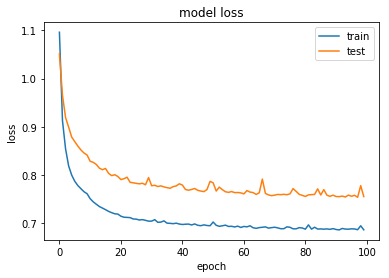

In [ ]:
predictions = autoencoder.predict(X1_test)
mse = np.mean(np.power(X1_test - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y1_test})
df_error.describe()

reconstruction_error   true_class
count           1792.000000  1792.000000
mean               0.653933     0.001116
std                3.618828     0.033398
min                0.056373     0.000000
25%                0.235051     0.000000
50%                0.392535     0.000000
75%                0.616404     0.000000
max              142.747947     1.000000

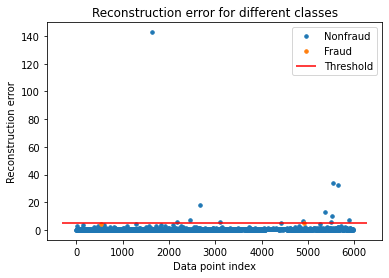

In [ ]:
set_threshold = 5
groups = df_error.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, 
            group.reconstruction_error, 
            marker='o', 
            ms=3.5, 
            linestyle='',
            label= "Fraud" if name == 1 else "Nonfraud")
    
ax.hlines(set_threshold, 
          ax.get_xlim()[0], 
          ax.get_xlim()[1], 
          colors="r", 
          zorder=100, 
          label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()